In [4]:
# # #Устанавливаем пакеты в окружение, если они не установлены

# # #библиотека для работы с изображениями в языке программирования Python
# !pip install pillow 

# # #библиотека языка Python, добавляющая поддержку больших многомерных массивов и матриц
# !pip install numpy

# # #Python­-пакет с открытым кодом, который работает с массивами NumPy
# !pip install scikit-image

# # #устанавливаем tensorflow для CPU
# !pip install tensorflow

# # #устанавливаем keras
# !pip install scikeras[tensorflow]

# # #отрисовка схем, графиков
# !pip install graphviz
# !pip install pydot

# !pip install matpLotLib

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import zipfile
import tensorflow as tf

from keras import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *

In [6]:
# data_r = zipfile.ZipFile('train.zip', 'r')
# data_r.extractall()

In [7]:
# data_r = zipfile.ZipFile('test.zip', 'r')
# data_r.extractall()

In [8]:
def download_data(path):
  data = []
  for path_image in sorted(os.listdir(path=path)):
    image = Image.open(path + path_image) #Открываем изображение.
    data.append(np.array(image)) #Загружаем пиксели.
  return data

* X_train – Исходные изображения из обучающей выборки данных.
* Y_train – Сегментированные исходные изображения из обучающей выборки.
* X_test – Исходные изображения из тестовой выборки данных.
* Y_test – Сегментированные исходные изображения из тестовой выборки.

In [9]:
X_train = download_data(r"train/images/")
Y_train = download_data(r"train/masks/")
X_test = download_data(r"test/images/")
Y_test = download_data(r"test/masks/")


In [10]:
X_train[0].shape

(644, 796, 3)

In [11]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

In [12]:
X_train, Y_train = resize(X_train, Y_train)

In [13]:
X_test, Y_test = resize(X_test, Y_test)

Объявление функций предобработки и пост обработки данных


In [14]:
# установка цвета полос
palette = {0 : (60, 16, 152), # Здания
           1 : (132, 41, 246), # Земля
           2 : (110, 193, 228), # Дороги
           3 : (254, 221, 58), # Растения
           4 : (226, 169, 41), # Вода
           5 : (155, 155, 155)} # Неразмечено

In [15]:
# обратное преобразование цвета в метку класса
invert_palette = {v: k for k, v in palette.items()}

In [16]:
# преобразование выхода нейронной сети в RGB изображение
def convert_to_color(arr_2d, palette=palette):
    """ Числовые метки для кодирования RGB-цвета """
    # zeros() возвращает новый массив указанной формы и типа, заполненный нулями.
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

# участвует в предикте

In [17]:
def convert_from_color(arr_3d, palette=invert_palette):
    """ Кодирование цвета RGB в полутоновый маркер """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    # принадлежность каждого пикселя классу
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.int8)

    # расстояние до ближайшего класса для пикселей
    min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000 

    for c, i in palette.items():
      # ищем расстояние для каждого пикселя до проверяемого класса по евклиду рас-ие
      distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2) 

      # поиск элементов меньше min_distance
      condition = min_distance > distance 

      # замена дистанции найденных элементов
      min_distance[condition] = distance[condition] 

      # замена класса найденных элементов
      arr_2d[condition] = i 

    for c, i in palette.items():
      m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
      arr_2d[m] = i

    arr_2d = arr_2d.tolist()
    for i in range(len(arr_2d)):
      for j in range(len(arr_2d[0])):
        label = [0, 0, 0, 0, 0, 0]
        label[arr_2d[i][j]] = 1
        arr_2d[i][j] = label
    arr_2d = np.array(arr_2d)

    return arr_2d

# участвует в обучении

Предобработка исходных изображений и сегментированных изображений в ответ сети

In [18]:
# Исходные изображения из обучающей выборки данных
X_train_pred = np.array(X_train).reshape([7, 128, 128, 3])/255

# Исходные изображения из тестовой выборки данных.
X_test_pred = np.array(X_test).reshape([2, 128, 128, 3])/255

# Сегментированные исходные изображения из обучающей выборки.
Y_train_pred = []
for i in range(len(Y_train)):
  Y_train_pred.append(convert_from_color(Y_train[i][:, :, :3]))
Y_train_pred = np.array(Y_train_pred)

# Сегментированные исходные изображения из тестовой выборки.
Y_test_pred = []
for i in range(len(Y_test)):
  Y_test_pred.append(convert_from_color(Y_test[i][:, :, :3]))
Y_test_pred = np.array(Y_test_pred)


Объявление топологии нейронной сети

In [19]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [20]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [21]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [22]:
def build_unet_model():
   # inputs
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(6, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [23]:
unet_model = build_unet_model()

In [24]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")

In [25]:
%%time

history = unet_model.fit(X_train_pred, Y_train_pred,  epochs=10, validation_data = (X_test_pred, Y_test_pred))

Epoch 1/10
1/1 [==============================] - 14s 14s/step - loss: 1.4117 - accuracy: 0.5245 - val_loss: 3.9084 - val_accuracy: 0.6051
Epoch 2/10
1/1 [==============================] - 7s 7s/step - loss: 9.8197 - accuracy: 0.6273 - val_loss: 1.0888 - val_accuracy: 0.6051
Epoch 3/10
1/1 [==============================] - 8s 8s/step - loss: 1.1212 - accuracy: 0.6273 - val_loss: 1.2228 - val_accuracy: 0.6055
Epoch 4/10
1/1 [==============================] - 8s 8s/step - loss: 1.2318 - accuracy: 0.6276 - val_loss: 1.2486 - val_accuracy: 0.6059
Epoch 5/10
1/1 [==============================] - 8s 8s/step - loss: 1.2652 - accuracy: 0.6282 - val_loss: 1.2134 - val_accuracy: 0.6057
Epoch 6/10
1/1 [==============================] - 7s 7s/step - loss: 1.2381 - accuracy: 0.6296 - val_loss: 1.1467 - val_accuracy: 0.6054
Epoch 7/10
1/1 [==============================] - 7s 7s/step - loss: 1.1833 - accuracy: 0.6342 - val_loss: 1.0762 - val_accuracy: 0.6053
Epoch 8/10
1/1 [=======================

In [26]:
out = unet_model.predict(X_test_pred[:2], batch_size=1)

2/2 [==============================] - 1s 278ms/step


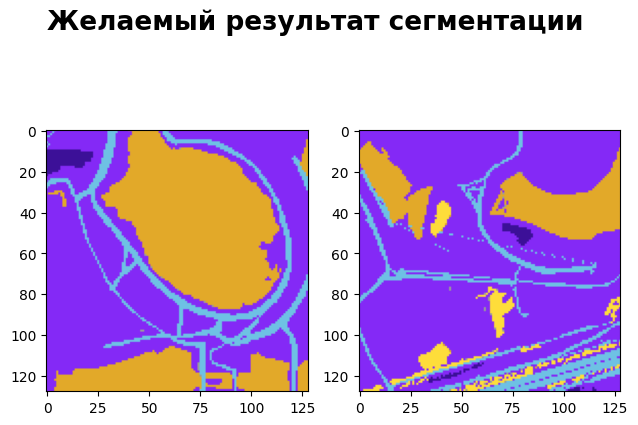

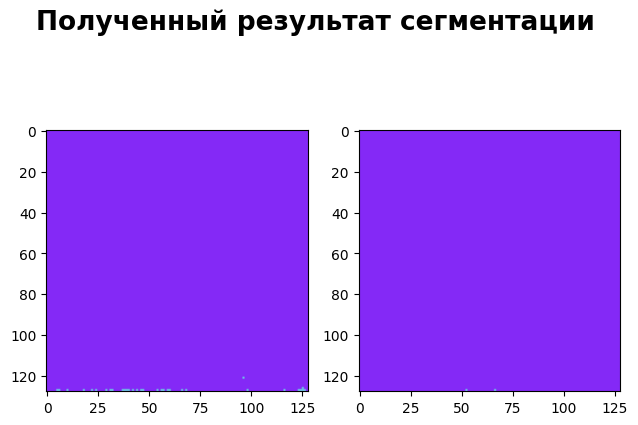

In [27]:
# Выведем 2-е тестовые картинки
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(convert_to_color(np.argmax(Y_test_pred[i], axis=-1)))
plt.suptitle('Желаемый результат сегментации', fontsize=19, fontweight='bold')
plt.tight_layout()
plt.show()

# Выведем 2-е картинки полученые методом predict
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(convert_to_color(np.argmax(out[i], axis=-1)))
plt.suptitle('Полученный результат сегментации', fontsize=19, fontweight='bold')
plt.tight_layout()
plt.show()

In [28]:
# def unet_model(image_size, output_classes):

#     #Входной слой
#     input_layer = Input(shape=image_size + (3,))
#     conv_1 = Conv2D(64, 4,
#                                     activation=LeakyReLU(),
#                                     strides=2, padding='same',
#                                     kernel_initializer='glorot_normal',
#                                     use_bias=False)(input_layer)
#     #Сворачиваем
#     conv_1_1 = Conv2D(128, 4,
#                                       activation=LeakyReLU(),
#                                       strides=2,
#                                       padding='same',
#                                       kernel_initializer='glorot_normal',
#                                       use_bias=False)(conv_1)
#     batch_norm_1 = BatchNormalization()(conv_1_1)

#     #2
#     conv_2 = Conv2D(256, 4,
#                                     activation=LeakyReLU(),
#                                     strides=2,
#                                     padding='same',
#                                     kernel_initializer='glorot_normal',
#                                     use_bias=False)(batch_norm_1)
#     batch_norm_2 = BatchNormalization()(conv_2)

#     #3
#     conv_3 = Conv2D(512, 4,
#                                     activation=LeakyReLU(),
#                                     strides=2,
#                                     padding='same',
#                                     kernel_initializer='glorot_normal',
#                                     use_bias=False)(batch_norm_2)
#     batch_norm_3 = BatchNormalization()(conv_3)

#     #4
#     conv_4 = Conv2D(512, 4,
#                                     activation=LeakyReLU(),
#                                     strides=2,
#                                     padding='same',
#                                     kernel_initializer='glorot_normal',
#                                     use_bias=False)(batch_norm_3)
#     batch_norm_4 = BatchNormalization()(conv_4)

#     #5
#     conv_5 = Conv2D(512, 4,
#                                     activation=LeakyReLU(),
#                                     strides=2,
#                                     padding='same',
#                                     kernel_initializer='glorot_normal',
#                                     use_bias=False)(batch_norm_4)
#     batch_norm_5 = BatchNormalization()(conv_5)

#     #6
#     conv_6 = Conv2D(512, 4,
#                                     activation=LeakyReLU(),
#                                     strides=2,
#                                     padding='same',
#                                     kernel_initializer='glorot_normal',
#                                     use_bias=False)(batch_norm_5)
#     ch, cw = get_crop_shape(conv_5,conv_5)
#       #Разворачиваем
#     #1
#     up_1 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
#                                                                           padding='same',
#                                                                           kernel_initializer='glorot_normal',
#                                                                           use_bias=False)(conv_6), conv_5])
#     batch_up_1 = BatchNormalization()(up_1)

#     #Добавим Dropout от переобучения
#     batch_up_1 = Dropout(0.25)(batch_up_1)

#     #2
#     up_2 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
#                                                                           padding='same',
#                                                                           kernel_initializer='glorot_normal',
#                                                                           use_bias=False)(batch_up_1), conv_4])
#     batch_up_2 = BatchNormalization()(up_2)
#     batch_up_2 = Dropout(0.25)(batch_up_2)




#     #3
#     up_3 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
#                                                                           padding='same',
#                                                                           kernel_initializer='glorot_normal',
#                                                                           use_bias=False)(batch_up_2), conv_3])
#     batch_up_3 = BatchNormalization()(up_3)
#     batch_up_3 = Dropout(0.25)(batch_up_3)




#     #4
#     up_4 = Concatenate()([Conv2DTranspose(256, 4, activation='relu', strides=2,
#                                                                           padding='same',
#                                                                           kernel_initializer='glorot_normal',
#                                                                           use_bias=False)(batch_up_3), conv_2])
#     batch_up_4 = BatchNormalization()(up_4)


#     #5
#     up_5 = Concatenate()([Conv2DTranspose(128, 4, activation='relu', strides=2,
#                                                                           padding='same',
#                                                                           kernel_initializer='glorot_normal',
#                                                                           use_bias=False)(batch_up_4), conv_1_1])
#     batch_up_5 = BatchNormalization()(up_5)


#     #6
#     up_6 = Concatenate()([Conv2DTranspose(64, 4, activation='relu', strides=2,
#                                                                           padding='same',
#                                                                           kernel_initializer='glorot_normal',
#                                                                           use_bias=False)(batch_up_5), conv_1])
#     batch_up_6 = BatchNormalization()(up_6)


#     #Выходной слой
#     output_layer = Conv2DTranspose(output_classes, 4, activation='sigmoid', strides=2,
#                                                    padding='same',
#                                                    kernel_initializer='glorot_normal')(batch_up_6)

#     model = Model(inputs=input_layer, outputs=output_layer)
#     return model

In [29]:
model = unet_model((796,644), 6)

ValueError: Layer "U-Net" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor: shape=(), dtype=int32, numpy=796>, <tf.Tensor: shape=(), dtype=int32, numpy=644>]

In [ ]:
#Функция для подсчёта DICE коэффициента
def dice_coef(y_pred, y_true):
    y_pred = tf.unstack(y_pred, axis=3)
    y_true = tf.unstack(y_true, axis=3)
    dice_summ = 0

    for i, (a_y_pred, b_y_true) in enumerate(zip(y_pred, y_true)):
        dice_calculate = (2 * tf.math.reduce_sum(a_y_pred * b_y_true) + 1) /\
         (tf.math.reduce_sum(a_y_pred + b_y_true) + 1)

        dice_summ += dice_calculate
    avg_dice = dice_summ/CLASSES
    return avg_dice

In [ ]:
#Функция для подсчета DICE loss
def dice_loss(y_pred, y_true):
    d_loss = 1 - dice_coef(y_pred, y_true)
    return d_loss

In [ ]:
# Binary crossentropy + 0.25 * DICE
def dice_bce_loss(y_pred, y_true):
    total_loss = 0.25 * dice_loss(y_pred, y_true) + keras.losses.binary_crossentropy(y_pred, y_true)
    return total_loss